# Tutorial 5b - Advanced Optimization

### June 2024

Building on tutorial 5a, this tutorial demonstrates further optimization functionalities including:

- Various operand types (paraxial, real ray-based, aberrations)
- Various variable types (radii, thickness, conic)
- Global optimization (e.g. dual annealing, differential evolution, SHGO, basin-hopping)

In [1]:
import numpy as np
from optiland import optic, analysis, optimization

Let's define a non-optimized doublet, which we will optimize. Our goal in optimization will be to:

- Control distortion via real ray intersection operands
- Minimize spherical aberration
- Minimize the spot size for each field
- Maintain a focal length of 50 mm

In [2]:
lens = optic.Optic()

lens.surface_group.surfaces = []

lens.add_surface(index=0, radius=np.inf, thickness=np.inf)
lens.add_surface(index=1, radius=50, thickness=5, material='N-BK7')
lens.add_surface(index=2, radius=-500, thickness=10)
lens.add_surface(index=3, radius=500, thickness=5, material='SK16', is_stop=True)
lens.add_surface(index=4, radius=-50, thickness=35)
lens.add_surface(index=5)

# add aperture
lens.set_aperture(aperture_type='EPD', value=8)

# add field
lens.set_field_type(field_type='angle')
lens.add_field(y=0)
lens.add_field(y=5.6)
lens.add_field(y=8)

# add wavelength
lens.add_wavelength(value=0.4861327)
lens.add_wavelength(value=0.5875618, is_primary=True)
lens.add_wavelength(value=0.6562725)

lens.update_paraxial()

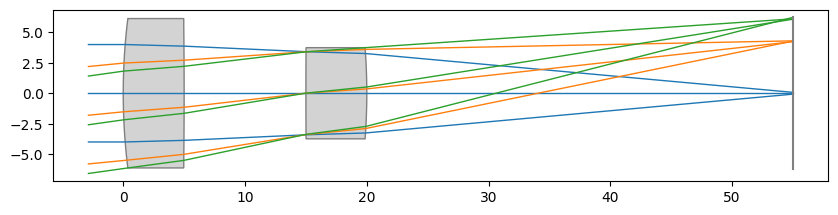

In [3]:
lens.draw()

Let's define the optimization problem. First, let's add the operands:

In [4]:
problem = optimization.OptimizationProblem()

# add real ray operands - the intersection location is f*tan(theta), where f is the focal length
# and theta is the field half angle
input_data = {'optic': lens, 'surface_number': 5, 'Hx': 0, 'Hy': 0.7, 'Px': 0, 'Py': 0, 'wavelength': 0.5875618}
problem.add_operand(operand_type='real_y_intercept', target=4.903, weight=1, input_data=input_data)

input_data = {'optic': lens, 'surface_number': 5, 'Hx': 0, 'Hy': 1, 'Px': 0, 'Py': 0, 'wavelength': 0.5875618}
problem.add_operand(operand_type='real_y_intercept', target=7.027, weight=1, input_data=input_data)

# add operand to minimize spherical aberration - we will minimize the first seidel aberration (i.e. #1)
input_data = {'optic': lens, 'seidel_number': 1}
problem.add_operand(operand_type='seidel', target=0, weight=1, input_data=input_data)

# add RMS spot size operand - let's minimize the spot size for each field at the primary wavelength
# we choose a 'uniform' distribution, so the number of rays actually means the rays on one axis. So,
# we acually trace ≈16^2 rays here.
for field in lens.fields.get_field_coords():
    input_data = {'optic': lens, 'surface_number': 5, 'Hx': field[0], 'Hy': field[1], 'num_rays': 16,
                  'wavelength': 0.5875618, 'distribution': 'uniform'}
    problem.add_operand(operand_type='rms_spot_size', target=0, weight=10, input_data=input_data)

# add focal length target
problem.add_operand(operand_type='f2', target=50, weight=1, input_data={'optic': lens})

Now, we can add the variables. Let's let one of the surfaces' conic constant vary. Lastly, we print the optimization problem information overview.

In [5]:
# thickness between the lenses and distance to image plane
problem.add_variable(lens, 'thickness', surface_number=2, min_val=3, max_val=30)
problem.add_variable(lens, 'thickness', surface_number=4, min_val=0, max_val=100)

# radii of all lenses
problem.add_variable(lens, 'radius', surface_number=1, min_val=-1000, max_val=1000)
problem.add_variable(lens, 'radius', surface_number=2, min_val=-1000, max_val=1000)
problem.add_variable(lens, 'radius', surface_number=3, min_val=-1000, max_val=1000)
problem.add_variable(lens, 'radius', surface_number=4, min_val=-1000, max_val=1000)

# conic constant of first lens surface
problem.add_variable(lens, 'conic', surface_number=1, min_val=-10, max_val=10)

# print optimization problem info
problem.info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |                32.7258 |                 0 |
+----+------------------------+-------------------+
+----+------------------+----------+----------+-------------+-------------+--------------------+
|    | Operand Type     |   Target |   Weight |       Value |       Delta |   Contribution (%) |
|----+------------------+----------+----------+-------------+-------------+--------------------|
|  0 | real y intercept |    4.903 |        1 |  4.23414    | -0.66886    |        1.36704     |
|  1 | real y intercept |    7.027 |        1 |  6.08148    | -0.945522   |        2.73183     |
|  2 | seidel           |    0     |        1 | -0.00619853 | -0.00619853 |        0.000117405 |
|  3 | rms spot size    |    0     |       10 |  0.0601404  |  0.0601404  |        1.10521     |
|  4 | rms spot size    |    0     |       10 |  0.0409341  |

Let's optimize our system. There are many optimizers available, but we want to demonstrate a global optimization method: Differential Evolution. Optiland utilizes the scipy implementation of this optimization method.

This method can take some time. To speed up the calculation, we parallize the calculation and use all available CPU cores. We specify this by supplying -1 to the workers argument.

In [6]:
optimizer = optimization.DifferentialEvolution(problem)
# optimizer = optimization.SHGO(problem)  # note SHGO requires bounds
# optimizer = optimization.BasinHopping(problem)  # note BasinHopping requires no bounds

res = optimizer.optimize(maxiter=256, disp=False, workers=-1)

Let's see how the lens has changed after optimization:

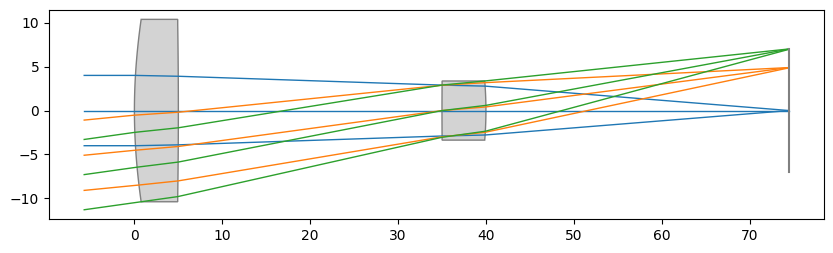

In [7]:
lens.draw()

By viewing the problem info, we can see that there was a greater than 99% improvement in performance, based on the defined operands.

In [8]:
problem.info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |             0.00696902 |           99.9787 |
+----+------------------------+-------------------+
+----+------------------+----------+----------+-------------+-------------+--------------------+
|    | Operand Type     |   Target |   Weight |       Value |       Delta |   Contribution (%) |
|----+------------------+----------+----------+-------------+-------------+--------------------|
|  0 | real y intercept |    4.903 |        1 |  4.88759    | -0.0154102  |           3.40755  |
|  1 | real y intercept |    7.027 |        1 |  6.99195    | -0.0350506  |          17.6286   |
|  2 | seidel           |    0     |        1 | -0.00412425 | -0.00412425 |           0.244072 |
|  3 | rms spot size    |    0     |       10 |  0.00238062 |  0.00238062 |           8.13222  |
|  4 | rms spot size    |    0     |       10 |  0.0040219  |

Let's perform a few analyses to check the final performance of our lens.

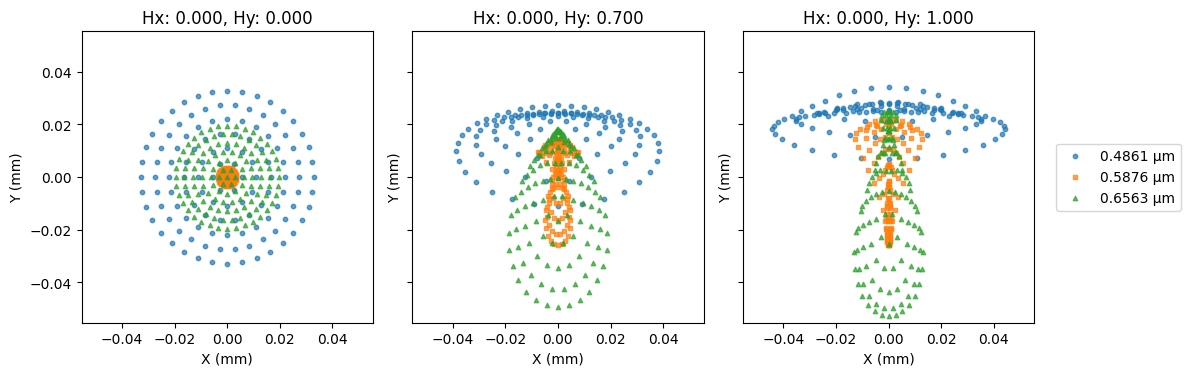

In [9]:
spot = analysis.SpotDiagram(lens)
spot.view()

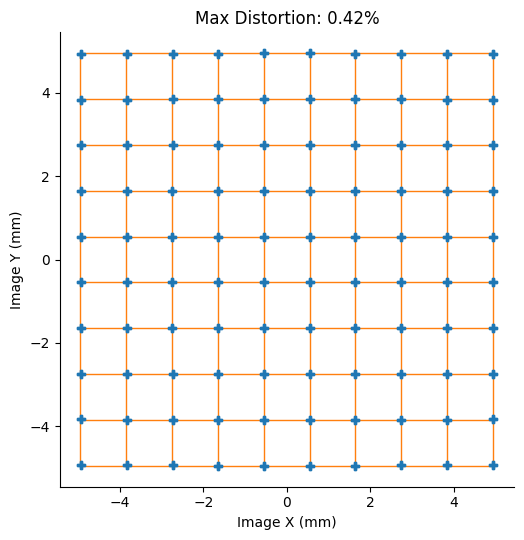

In [11]:
grid = analysis.GridDistortion(lens)
grid.view()

In [10]:
print('Seidel Aberrations:')
for k, seidel in enumerate(lens.aberrations.seidels()):
    print(f'\tS{k+1}: {seidel:.3e}')

Seidel Aberrations:
	S1: -4.124e-03
	S2: 4.749e-03
	S3: -6.648e-03
	S4: -5.012e-03
	S5: 1.305e-02


Conclusions:

- We showed several different operands and variables that can be used in optimization.
- We demonstrated the use of differential evolution for optimization
- While the lens itself improved in performance, there is still room for improvement. Different operands, variables, or sequences of optimization steps would result in different, and possibly better, results.